# Combining DFT and McStas: Powder diffraction analysis over a range of wavelengths on a DFT-optimized structure, using McStas.

Gergely Nagy (ELI-ALPS), Mads Bersten (ESS - ERIC), Mousumi Upadhyay Kahaly (ELI-ALPS) (mousumi.upadhyaykahaly@eli-alps.hu)

### Requirements:
- a working [McStas](https://www.mcstas.org) 2.7+ installation (instructions: https://github.com/McStasMcXtrace/McCode/blob/master/INSTALL-McStas-2.x/README.md)
- McStasScript (https://github.com/PaNOSC-ViNYL/McStasScript)
- Common scientific Python modules: Numpy, Matplotlib...

In this notebook, we follow through the steps of performing the simulation of a powder diffraction experiment over a range of neutron wavelengths using the [D2B instrument](https://www.ill.eu/users/instruments/instruments-list/d2b/description/instrument-layout) located in ILL. 

In [1]:
import os

In [2]:
import mmap
from timeit import default_timer as timer

import numpy as np
from matplotlib import pyplot as plt
from mcstasscript.interface import reader, functions, instr, plotter
from mcstasscript.interface.functions import load_data
from datetime import timedelta

## Generate instrument file
First we have to generate a McStasScript Python module of the McStas instrument, if we haven't do this before:

In [3]:
Reader = reader.McStas_file("ILL_D2B.instr")
try:
  Reader.write_python_file("ILL_D2B.py")
except ValueError as e:
  print("The instrument's Python module already exists, so it is left untouched.")

In [4]:
from ILL_D2B import ILL_D2B as instrument

If we want, we can take a look at the instrument itself:

In [5]:
SHOW_INSTRUMENT = False
if SHOW_INSTRUMENT:
    instrument.show_instrument()

## Process the structures 

We can obtain a force- and energy minimized, relaxed structure from DFT calculations conducted with e.g. [Quantum Espresso](https://www.quantum-espresso.org). The corresponding final structure is then should be converted to a CIF file for further processing. 

In this notebook, we compare a few boron-doped diamond structures:

![structures](Structures.png "The five structures, their Brillouin cell
with a k-path suitable for band structure analysis, and the boron-boron
distances in C14B2 systems.")

Below we give the path to the CIF files.

In [6]:
crystal_cifs = {
    "c16": "cifs/c16.cif",
    "c15b1": "cifs/c15b1.cif",
    "c14b2a": "cifs/c14b2a.cif",
    "c14b2b": "cifs/c14b2b.cif",
    "c14b2c": "cifs/c14b2c.cif"
}

We need to get the crystal reflections from these. We use the cif2hkl code developed by E. Farhi, available at https://github.com/farhi/cif2hkl. This code is shipped with McStas by default, but if it's not available, we can download and build it ourselves. The following script does this (gfortran is needed for building).

In [7]:
%%bash
wget -O - https://github.com/farhi/cif2hkl/tarball/master | tar -xz
cd farhi-cif2hkl-*
make 
cp cif2hkl ../ && cd .. && rm -rf farhi-cif2hkl-*


f77 -ffree-line-length-512 \
CFML/CFML_GlobalDeps_Linux.f90 CFML/CFML_Math_Gen.f90 \
CFML/CFML_String_Util_gf.f90   CFML/CFML_Math_3D.f90 \
CFML/CFML_Sym_Table.f90        CFML/CFML_Chem_Scatt.f90 \
CFML/CFML_Symmetry.f90         CFML/CFML_Cryst_Types.f90 \
CFML/CFML_Reflct_Util.f90      CFML/CFML_Atom_Mod.f90 \
CFML/CFML_Geom_Calc.f90        CFML/CFML_Molecules.f90 \
CFML/CFML_Diffpatt.f90         CFML/CFML_Magnetic_Groups.f90 \
CFML/CFML_EisPack.f90          CFML/CFML_Form_CIF.f90 \
CFML/CFML_Sfac.f90 -o cif2hkl cif2hkl.F90 -lm
rm *.mod


--2022-01-25 13:36:26--  https://github.com/farhi/cif2hkl/tarball/master
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/farhi/cif2hkl/legacy.tar.gz/master [following]
--2022-01-25 13:36:26--  https://codeload.github.com/farhi/cif2hkl/legacy.tar.gz/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘STDOUT’

     0K .......... .......... .......... .......... .......... 1.21M
    50K .......... .......... .......... .......... .......... 2.49M
   100K .......... .......... .......... .......... .......... 41.9M
   150K .......... .......... .......... .......... .......... 61.8M
   200K .......... .......... .......... ..

Time to convert the cif files to hkl:

In [8]:
path_to_cif2hkl = "./cif2hkl"
hkl_folder = "./hkl"
crystal_hkls = {}
# create hkl folder 
if not os.path.exists(hkl_folder):
    os.makedirs(hkl_folder)
for name, cif in crystal_cifs.items():
    hkl_fname = os.path.splitext(os.path.basename(cif))[0] + ".hkl"
    hkl_file = os.path.join(hkl_folder, hkl_fname)
    if not os.path.exists(hkl_folder):
        os.makedirs(hkl_folder)
    os.system(f"{path_to_cif2hkl} --powder -o {hkl_file} {cif}")
    crystal_hkls[name] = hkl_file

## Setup

Here we give various options for the simulation.

In [9]:
# place of Mcstas output
output_folder = "./results"

# prefix of McStas output folder
prefix = "d2b_test"

# Additional postfix of the output folder (e.g. "_0", "_1", ...)
postfix = ""

# If True, the simulation is executed (this takes some time). If false, the 
# results of the previous run at the same location will be loaded instead.
run_simulation = True  

# The name of the detector in the Mcstas instrument we want to use:
instrument_name = "D2B_BananaTheta"

# number of mpi threads used to run McStas
mpi = 12

# ray count for the McStas simulation
ncount = 1e8

# Walengths we scan over
lambda0s = 1.0, 1.5, 2.0, 2.5

# Color list used for the plots
colors = ["royalblue", "olivedrab", "red", "blue", "pink"]

These two functions below will parse the HKL files and extract the parameters used by McStas. They will be useful later.

In [11]:

def read_hkl(hkl_file):
    "read physical parameters from HKL files produced by cif2hkl"
    params = [
        "sigma_coh", "sigma_inc", "sigma_abs", "density", "weight", "Vc", 
        "lattice_a", "lattice_b", "lattice_c", "lattice_aa", "lattice_bb",
        "lattice_cc",
    ]
    vals = {}
    with open(hkl_file, "r+b") as f:
        with mmap.mmap(f.fileno(), 0) as mm:
            for pm in params:
                # find the pm string in the file and seek there
                mm.seek(mm.find(pm.encode("UTF-8")))
                # read the line, extract the value, and store in dict
                vals[pm] = float(mm.readline().strip().split()[1])

    return vals
def hkl_to_powdern_pms(hkl_file):
    "Parse the hkl file and return a dict with suitable PowderN input parameters."
    hkl_data = read_hkl(hkl_file)
    pms = {
        "Vc": hkl_data["Vc"],
        "density": hkl_data["density"],
        "weight": hkl_data["weight"],
        "sigma_abs": hkl_data["sigma_abs"],
        "sigma_inc": hkl_data["sigma_inc"],
        "reflections": '"' + hkl_file + '"',
        "barns": 1,
    }
    return pms

## Simulation

Run the McStas simulation on all samples and wavelengths. This will take some time.

In [12]:

def run_on_sample(sample_name, hkl_file, lambda0, ncount, mpi):
    "Run the instrument on a given crystal powder sample."
    
    # create output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # read the crystal parameters from the hkl file, and set the Sample component accordingly
    pms = hkl_to_powdern_pms(hkl_file)
    sample_comp = instrument.get_component("Sample")
    sample_comp.set_parameters(pms)
    
    # execute the simulation
    foldername = f"{output_folder}/{prefix}_{lambda0:.1f}_{sample_name}"
    data = instrument.run_full_instrument(
        foldername=foldername,
        increment_folder_name=True,
        ncount=ncount,
        mpi=mpi,
        parameters={
            "lambda": lambda0,
            "RV": -1,
            "verbose": 1,
            },
    )
    return data

In [14]:
if run_simulation:
    # execute the simulation for all wavelengths on all samples
    results = {}
    for i, lambda0 in enumerate(lambda0s):
        results[lambda0] = {}
        for j, (crys, hkl) in enumerate(crystal_hkls.items()):
            print(f"Running simulation for {crys} ({j+1}/{len(crystal_hkls.keys())}) at wl={lambda0:.2f} ({i+1}/{len(lambda0s)})...")
            start = timer()
            data = run_on_sample(crys, hkl, lambda0, ncount, mpi)
            end = timer()
            results[lambda0][crys] = data
            print("Simulation for " + crys + f" at wl={lambda0:.2f} finished in {timedelta(seconds=end-start)}.")

Running simulation for c16 (1/5) at wl=1.00 (1/4)...
INFO: Using directory: "/home/nagyg/Projects/McStas_and_DFT/Code/PanLearning-notebooks/01_wl_scan_on_CB_with_D2B/./results/d2b_test_1.0_c16_0"
INFO: Regenerating c-file: ILL_D2B_generated.c
Info:    Defining SPLIT from Monok=Monochromator_curved() to END in instrument ILL_D2B_generated
Info:    Defining SPLIT from Arm_Sample=Arm() to END in instrument ILL_D2B_generated
CFLAGS=
INFO: Recompiling: ./ILL_D2B_generated.out
/usr/local/mcstas/2.7.1/tools/Python/mcrun/../mccodelib/../../../monitors/Monitor_nD.comp: In function ‘off_init’:
/usr/local/mcstas/2.7.1/tools/Python/mcrun/../mccodelib/../../../monitors/Monitor_nD.comp:2841:7: warning: ignoring return value of ‘fgets’, declared with attribute warn_unused_result [-Wunused-result]
/usr/local/mcstas/2.7.1/tools/Python/mcrun/../mccodelib/../../../monitors/Monitor_nD.comp:2928:7: warning: ignoring return value of ‘fgets’, declared with attribute warn_unused_result [-Wunused-result]
/usr/

If we don't run the simulation, read the results of the previous run.

In [17]:
if not run_simulation:
    results = {}
    for lambda0 in lambda0s:
        results[lambda0] = {}
        for crys in crystal_hkls.keys():
            folder = f"{output_folder}/{prefix}_{lambda0:.1f}_{crys}{postfix}"
            data = load_data(folder)
            print(f"loaded {crys} @ wl={lambda0:.2f} from {folder}")
            results[lambda0][crys] = data

loaded c16 @ wl=1.00 from ./test_d2b/d2b_test_1.0_c16
loaded c15b1 @ wl=1.00 from ./test_d2b/d2b_test_1.0_c15b1
loaded c14b2a @ wl=1.00 from ./test_d2b/d2b_test_1.0_c14b2a
loaded c14b2b @ wl=1.00 from ./test_d2b/d2b_test_1.0_c14b2b
loaded c14b2c @ wl=1.00 from ./test_d2b/d2b_test_1.0_c14b2c
loaded c16 @ wl=1.50 from ./test_d2b/d2b_test_1.5_c16
loaded c15b1 @ wl=1.50 from ./test_d2b/d2b_test_1.5_c15b1
loaded c14b2a @ wl=1.50 from ./test_d2b/d2b_test_1.5_c14b2a
loaded c14b2b @ wl=1.50 from ./test_d2b/d2b_test_1.5_c14b2b
loaded c14b2c @ wl=1.50 from ./test_d2b/d2b_test_1.5_c14b2c
loaded c16 @ wl=2.00 from ./test_d2b/d2b_test_2.0_c16
loaded c15b1 @ wl=2.00 from ./test_d2b/d2b_test_2.0_c15b1
loaded c14b2a @ wl=2.00 from ./test_d2b/d2b_test_2.0_c14b2a
loaded c14b2b @ wl=2.00 from ./test_d2b/d2b_test_2.0_c14b2b
loaded c14b2c @ wl=2.00 from ./test_d2b/d2b_test_2.0_c14b2c
loaded c16 @ wl=2.50 from ./test_d2b/d2b_test_2.5_c16
loaded c15b1 @ wl=2.50 from ./test_d2b/d2b_test_2.5_c15b1
loaded c14b2

## Plot the results

Plot the results on a shared plot for the C16, C15B1 and C14B2a systems, and then for the three C14B2 systems for comparsion, for all wavelengths.

In [15]:
def plot_diffr(crystals_to_plot):
    for lambda0 in lambda0s:
        fig, ax = plt.subplots(figsize=(11, 5.5))
        for i, crys in enumerate(crystals_to_plot):
            # read data and metadata from the Mcstas output (we also read some 
            # metadata that isn't used in this example, but may be useful.
            data = results[lambda0][crys]
            pattern = functions.name_search(instrument_name, data)
            name = pattern.metadata.component_name
            xlabel = pattern.metadata.xlabel
            ylabel = pattern.metadata.ylabel
            xlims = pattern.metadata.limits
            intensity = pattern.Intensity
            ncount = pattern.Ncount
            error = pattern.Error
            xvals = pattern.xaxis
        
            # plot the detected intensity
            y = intensity
            ax.plot(xvals, y, color=colors[i], label=crys, linewidth=0.8)
            ax.fill_between(xvals, y, color=colors[i], alpha=0.1)
        
        # set log y-scale, labels, etc.
        ax.set_xlim(20, 99)
        ax.set_ylim(1e-1, 1e3)
        ax.set_yscale("log")
        ax.set_xlabel(r"$\theta$ (deg)", labelpad=0)
        ax.set_ylabel(ylabel)
        ax.grid(alpha=0.8, lw=0.5)
        fig.suptitle(rf"Powder diffraction signal for $\lambda={lambda0:.1f}Å$")
        ax.legend()
        plt.show()


plot_diffr(['c16', 'c15b1', 'c14b2a'])

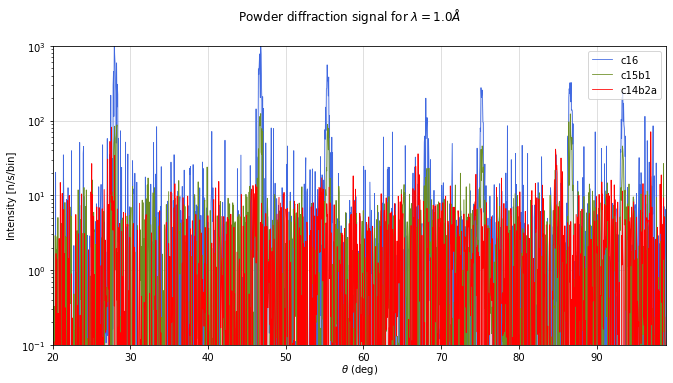

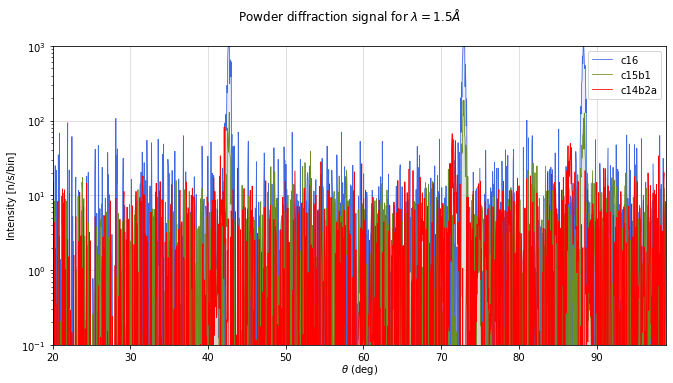

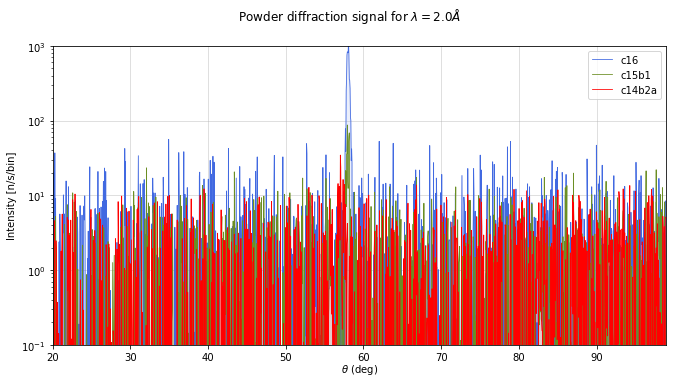

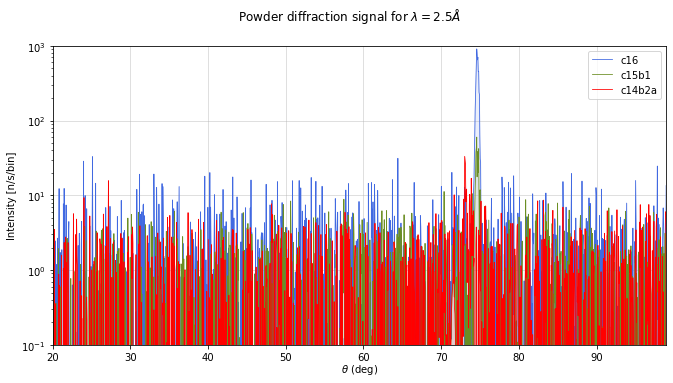

In [16]:
plot_diffr(['c16', 'c15b1', 'c14b2a'])

Plot for the three possible $C_{14}B_2$ structures:

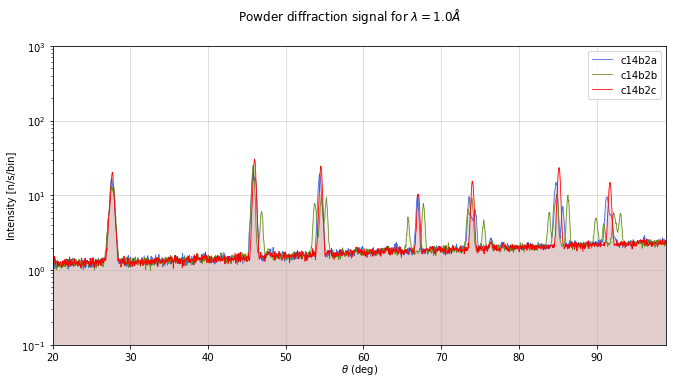

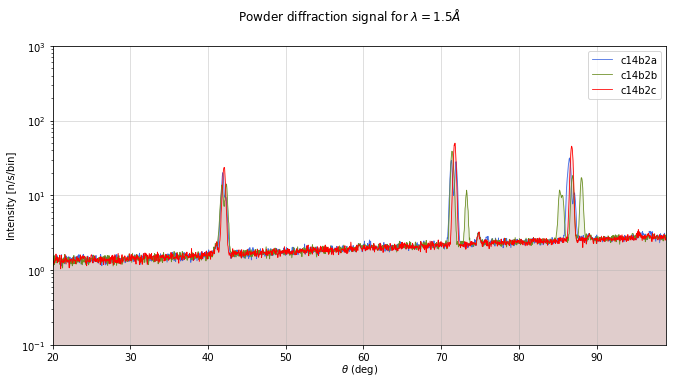

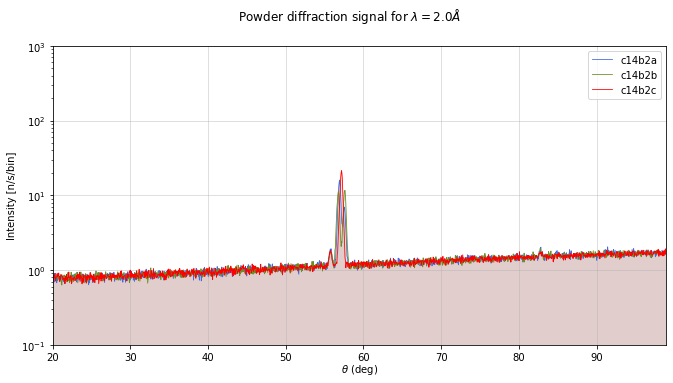

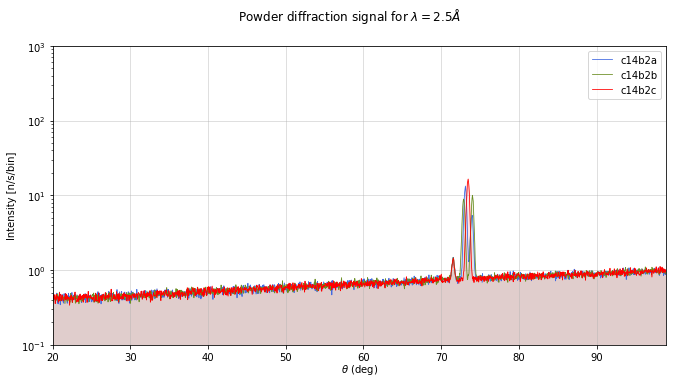

In [22]:

plot_diffr(['c14b2a', 'c14b2b', 'c14b2c'])